<a href="https://colab.research.google.com/github/abhinavtk1/CS6910-A1/blob/main/Q7_confusionMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MA23M002 - ABHINAV T K <br> CS6910 - Assignment 1

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Neural Net Code

In [ ]:
class NeuralNetwork:
  def __init__(self, x, y, x_test, y_test):
    self.x = x
    self.y = y
    self.x_test = x_test
    self.y_test = y_test
    self.c = len(np.unique(y))        # no. of classes

     # Class names - the index of the class names corresponds to the class label
    self.classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    self.hl = 0       # No. of hidden layers
    self.nn = 0       # No. of neurons in a hidden layer
  def preprocess(self):
    # change shape
    self.x = self.x.reshape(self.x.shape[0], -1)
    self.inp_features = self.x.shape[1]    # no. of input features

    self.x_test = self.x_test.reshape(self.x_test.shape[0], -1)
    # normalize data
    self.x = self.x/255.0
    self.x_test = self.x_test/255.0

  def split_data(self):
    self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x, self.y, test_size=0.1,random_state=42)

  def print_data_details(self):
    print("Total no. of classes = ", self.c)
    print("The class names are: ", self.classes)
    print("Number of input features = ", self.inp_features)

    # training samples size
    self.m = self.x_train.shape[0]
    print("Training samples = ", self.m)

    # validation samples size
    self.m_val = self.x_val.shape[0]
    print("Validation samples = ", self.m_val)

    # test samples size
    self.m_test = self.x_test.shape[0]
    print("Test samples = ", self.m_test)

  def one_hot_encod(self):
    self.y_train_encoded = np.eye(np.max(self.y_train) + 1)[self.y_train].T
    self.y_val_encoded = np.eye(np.max(self.y_val) + 1)[self.y_val].T
    self.y_test_encoded = np.eye(np.max(self.y_test) + 1)[self.y_test].T
    return self.y_train_encoded, self.y_val_encoded, self.y_test_encoded
  # Initializing parameters W and b
  def initialize_parameters(self, nn_layers, weight_init="random"):
    '''
    nn_layers: a list containing the number of neurons of each layer - where each layer no. is the index of the list
    '''
    np.random.seed(42)
    parameters = {}                         # dictionary to hold weights and biases of each layer
    u_t = {}
    for i in range(1, len(nn_layers)):
      if weight_init == "xavier":
        parameters["W"+str(i)] = np.random.randn(nn_layers[i],nn_layers[i-1])*np.sqrt(2/(nn_layers[i]+nn_layers[i-1]))
        parameters["b"+str(i)] = np.random.randn(nn_layers[i], 1)*np.sqrt(2/(nn_layers[i]))
      elif weight_init == "random":
        parameters["W"+str(i)] = np.random.randn(nn_layers[i], nn_layers[i-1])
        parameters["b"+str(i)] = np.random.randn(nn_layers[i], 1)

      u_t["W"+str(i)] = np.zeros((nn_layers[i], nn_layers[i-1]))
      u_t["b"+str(i)] = np.zeros((nn_layers[i], 1))
    return parameters, u_t

  # Activation functions
  def relu(self, x):
    return np.maximum(0,x)

  def tanh(self, x):
      return np.tanh(x)

  def sigmoid(self, x):
      return 1 / (1 + np.exp(-x))

  def softmax(self, x):
      return np.exp(x) / np.sum(np.exp(x), axis=0)

  # Derivatives of activation functions

  def sigmoid_grad(self, x):
      return self.sigmoid(x) * (1-self.sigmoid(x))

  def relu_grad(self, x):
      return 1*(x>0)

  def tanh_grad(self, x):
      return (1 - (np.tanh(x)**2))

  def softmax_grad(self, x):
      return self.softmax(x) * (1-self.softmax(x))


 # Forward propagation
  def forward_propagation(self, x, nn_layers, parameters, act_fn):

    l = len(nn_layers)  # No. of neural network layers, including input and output layers

    a = {}              # dictionary to hold hidden layer (pre-activation)
    h = {}              # dictionary to hold hidden layer (activation)

    h[0] = x.T  # input layer

    for i in range(1, l-1):
      W = parameters["W"+str(i)]        # weights of hidden layer i
      b = parameters["b"+str(i)]        # bias of hidden layer i

      a[i] = np.matmul(W,h[i-1]) + b

      # activation for hidden layers
      if act_fn == 'sigmoid':
        h[i] = self.sigmoid(a[i])
      elif act_fn == 'relu':
        h[i] = self.relu(a[i])
      elif act_fn == 'tanh':
        h[i] = self.tanh(a[i])

    # output layer
    W = parameters["W"+str(l-1)]              # weights of hidden layer i
    b = parameters["b"+str(l-1)]              # bias of hidden layer i

    a[l-1] = np.matmul(W,h[l-2]) + b          # activation function for output layer

    y_hat = self.softmax(a[l-1])
    return y_hat, h, a                # Returns y_hat, h, a

  # Backpropagation
  def back_propagation(self, y_hat, y, h, a, nn_layers, parameters, act_fn, batch_size, l2_reg):
    l = len(nn_layers)
    grads = {}            # dictionary to store gradient of loss function wrt parameters and hidden layer neurons

    # Computing gradient wrt output layer
    grads["grada"+str(l-1)] = y_hat - y

    for i in range(l-1,0,-1):
      grads["gradW" + str(i)] = (1/batch_size) * (np.dot(grads["grada" + str(i)], h[i-1].T) + l2_reg*parameters["W"+str(i)])
      grads["gradb" + str(i)] = (1/batch_size) * np.sum(grads["grada" + str(i)], axis=1, keepdims=True)
      if i>1:
        if act_fn == 'sigmoid':
          grads["grada"+str(i-1)] = np.matmul(parameters["W" + str(i)].T, grads["grada" + str(i)]) * self.sigmoid_grad(a[i-1])   # Computing gradients wrt hidden layers
        elif act_fn == 'relu':
          grads["grada"+str(i-1)] = np.matmul(parameters["W" + str(i)].T, grads["grada" + str(i)]) * self.relu_grad(a[i-1])
        elif act_fn == 'tanh':
          grads["grada"+str(i-1)] = np.matmul(parameters["W" + str(i)].T, grads["grada" + str(i)]) * self.tanh_grad(a[i-1])
    return grads

  # Update parameter based on different optimizers
  def sgd(self, parameters, grads , lr):
    l = self.hl + 1    # no. of hidden layers + outer layer
    for i in range(1, l + 1):
        parameters["W" + str(i)] = parameters["W" + str(i)] - lr * grads["gradW" + str(i)]
        parameters["b" + str(i)] = parameters["b" + str(i)] - lr * grads["gradb" + str(i)]
    return parameters

  def momentum(self, parameters, grads , lr, beta, u_t):
    # u_t: accumulating history of the gradient of the parameters

    l = self.hl + 1     # no. of hidden layers + outer layer
    for i in range(1, l + 1):
      u_t["W"+str(i)] = beta*u_t["W"+str(i)] + lr*grads["gradW" + str(i)]
      u_t["b"+str(i)] = beta*u_t["b"+str(i)] + lr*grads["gradb" + str(i)]

      parameters["W" + str(i)] = parameters["W" + str(i)] - u_t["W"+str(i)]
      parameters["b" + str(i)] = parameters["b" + str(i)] - u_t["b"+str(i)]

    return parameters, u_t

  def nesterov(self, parameters, grads , lr, beta, u_t):
    # u_t: accumulating history of the gradient of the parameters

    l = self.hl + 1     # no. of hidden layers + outer layer
    for i in range(1, l + 1):
      u_t["W"+str(i)] = beta*u_t["W"+str(i)] + lr*grads["gradW" + str(i)]
      u_t["b"+str(i)] = beta*u_t["b"+str(i)] + lr*grads["gradb" + str(i)]

      parameters["W" + str(i)] = parameters["W" + str(i)] - u_t["W"+str(i)]
      parameters["b" + str(i)] = parameters["b" + str(i)] - u_t["b"+str(i)]
    return parameters, u_t

  def rmsprop(self, parameters, grads, lr, beta, v_t):
    # adapts learning rate of each parameter based on magnitude of recent gradients
    # v_t: history of the gradient of parameters

    l = self.hl + 1         # no. of hidden layers + outer layer
    eps = 1e-4
    for i in range(1, l + 1):

        v_t["W"+str(i)] = beta*v_t["W" + str(i)] + (1-beta)*np.square(grads["gradW" + str(i)])
        v_t["b"+str(i)] = beta*v_t["b" + str(i)] + (1-beta)*np.square(grads["gradb" + str(i)])

        parameters["W" + str(i)] = parameters["W" + str(i)] - lr * grads["gradW" + str(i)] / (np.sqrt(v_t["W"+str(i)] + eps))
        parameters["b" + str(i)] = parameters["b" + str(i)] - lr * grads["gradb" + str(i)] / (np.sqrt(v_t["b"+str(i)] + eps))
    return parameters, v_t

  def adam(self, parameters, grads, lr, m_w, v_w, step):
    l = self.hl + 1       # number of layers in the neural network
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8

    for i in range(1, l+1):
        # computing intermediate values
        m_w["W"+str(i)] = beta1*m_w["W"+str(i)] + (1-beta1)*grads["gradW"+str(i)]
        m_w["b"+str(i)] = beta1*m_w["b"+str(i)] + (1-beta1)*grads["gradb"+str(i)]
        v_w["W"+str(i)] = beta2*v_w["W"+str(i)] + (1-beta2)*np.square(grads["gradW"+str(i)])
        v_w["b"+str(i)] = beta2*v_w["b"+str(i)] + (1-beta2)*np.square(grads["gradb"+str(i)])

        m_w_hat = m_w["W"+str(i)]/(1.0 - beta1**step)
        m_b_hat = m_w["b"+str(i)]/(1.0 - beta1**step)
        v_w_hat = v_w["W"+str(i)]/(1.0 - beta2**step)
        v_b_hat = v_w["b"+str(i)]/(1.0 - beta2**step)

        #update parameters
        parameters["W"+str(i)] = parameters["W"+str(i)] - (lr * m_w_hat)/np.sqrt(v_w_hat + eps)
        parameters["b"+str(i)] = parameters["b"+str(i)] - (lr * m_b_hat)/np.sqrt(v_b_hat + eps)

    step = step + 1
    return parameters, m_w, v_w, step

  def nadam(self, parameters, grads, lr, m_w, v_w, step):

    l = self.hl + 1     # number of layers in the neural network
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8

    for i in range(1, l+1):
        # computing intermediate values
        m_w["W"+str(i)] = beta1*m_w["W"+str(i)] + (1-beta1)*grads["gradW"+str(i)]
        m_w["b"+str(i)] = beta1*m_w["b"+str(i)] + (1-beta1)*grads["gradb"+str(i)]
        v_w["W"+str(i)] = beta2*v_w["W"+str(i)] + (1-beta2)*np.square(grads["gradW"+str(i)])
        v_w["b"+str(i)] = beta2*v_w["b"+str(i)] + (1-beta2)*np.square(grads["gradb"+str(i)])

        m_w_hat = m_w["W"+str(i)]/(1.0 - beta1**step)
        m_b_hat = m_w["b"+str(i)]/(1.0 - beta1**step)
        v_w_hat = v_w["W"+str(i)]/(1.0 - beta2**step)
        v_b_hat = v_w["b"+str(i)]/(1.0 - beta2**step)

        #update parameters
        parameters["W"+str(i)] = parameters["W"+str(i)] - (lr /np.sqrt(v_w_hat + eps))*(beta1*m_w_hat +
                                                                                        (1-beta1)*grads["gradW"+str(i)]/(1.0 - beta1**step))
        parameters["b"+str(i)] = parameters["b"+str(i)] - (lr /np.sqrt(v_b_hat + eps))*(beta1*m_b_hat +
                                                                                        (1-beta1)*grads["gradb"+str(i)]/(1.0 - beta1**step))

    step = step + 1
    return parameters, m_w, v_w, step

  def compute_loss(self, y, y_hat, batch_size, parameters, l2_reg):

    wt_norm_sq = 0
    for i in range(1, self.hl+2):
        wt_norm_sq = wt_norm_sq + np.sum(np.square(parameters["W"+str(i)]))

    loss_val = (-1/batch_size)*(np.sum(np.multiply(y, np.log(y_hat))) + 0.5*l2_reg*wt_norm_sq)
    return loss_val

  # Plotting function
  def plot_loss_curve(self, training_loss, validation_loss):
      """
      Plot the training and validation loss curves.
      """
      n1 = len(training_loss)
      n2 = len(validation_loss)
      plt.plot(list(range(n1)), training_loss, 'b', label="Training Loss")
      plt.plot(list(range(n2)), validation_loss, 'r', label="Validation Loss")

      # Adding title and labels
      plt.title("Training and Validation Loss vs Epochs")
      plt.xlabel("# Epochs")
      plt.ylabel("Loss")

      plt.grid()
      plt.legend()
      plt.show()

  def train_model(self, epochs = 10, num_hidden_layers = 3, num_neurons = 128, lr = 0.001, act_fn = 'relu',
                    weight_init = 'xavier', optimizer = 'momentum',  batch_size = 512, l2_reg = 0.0005):

    '''
    number of epochs: 5, 10
    number of hidden layers: 3, 4, 5
    size of every hidden layer: 32, 64, 128
    weight decay (L2 regularisation): 0, 0.0005, 0.5
    learning rate: 1e-3, 1e-4
    optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
    batch size: 16, 32, 64
    weight initialisation: random, xavier
    activation functions: sigmoid, tanh, relu
    '''

    self.hl = num_hidden_layers
    self.nn = num_neurons
    nn_layers = [self.inp_features] + [self.nn]*self.hl + [self.c]
    parameters, u_t = self.initialize_parameters(nn_layers, weight_init)

    params_lookahead = parameters.copy()                 # look ahead parameters init for nesterov/nadam

    # adam/nadam optimizer utils
    m_w = u_t.copy()
    v_w = u_t.copy()
    step = 1

    l = num_hidden_layers + 1                                # no. of hidden layers + outer layer
    beta = 0.9                                                # decay rate


    training_loss = []
    validation_loss = []
    if optimizer == 'sgd':
        batch_size = 1
    for epoch in range(1, epochs+1):
      for i in range(0, self.x_train.shape[0], batch_size):
        batch_sz = min(batch_size, self.x_train.shape[0] - i)
        y_hat, h, a = self.forward_propagation(self.x_train[i:i+batch_sz,:], nn_layers, parameters, act_fn)
        if optimizer == 'nesterov' or optimizer == 'nadam':
          # calculating look-ahead parameters
          for j in range(1, l+1):
            params_lookahead["W"+str(j)] = parameters["W"+str(j)] - beta*u_t["W"+str(j)]
            params_lookahead["b"+str(j)] = parameters["b"+str(j)] - beta*u_t["b"+str(j)]
          # calculating gradients of look-ahead
          grads = self.back_propagation(y_hat, self.y_train_encoded[:,i:i+batch_sz], h, a, nn_layers, params_lookahead, act_fn, batch_sz, l2_reg)
          if optimizer == 'nesterov':
            parameters, u_t = self.nesterov(parameters, grads , lr, beta, u_t)
          elif optimizer == 'nadam':
            parameters, m_w, v_w, step = self.nadam(parameters, grads, lr, m_w, v_w, step)

        else:
          grads = self.back_propagation(y_hat, self.y_train_encoded[:,i:i+batch_sz], h, a, nn_layers, parameters, act_fn, batch_sz, l2_reg)
          if optimizer == 'sgd':
            parameters = self.sgd(parameters, grads, lr)
          elif optimizer == 'momentum':
            parameters, u_t = self.momentum(parameters, grads , lr, beta, u_t)
          elif optimizer == 'rmsprop':
            parameters, u_t = self.rmsprop(parameters, grads , lr, beta, u_t)
          elif optimizer == 'adam':
            parameters, m_w, v_w, step = self.adam(parameters, grads, lr, m_w, v_w, step)

      # model evaluation
      y_hat, _, _ = self.forward_propagation(self.x_train, nn_layers, parameters, act_fn)
      cost = self.compute_loss(self.y_train_encoded, y_hat, y_hat.shape[1], parameters, l2_reg)
      training_loss.append(cost)

      #one-hot encoding y_hat
      y_hat_encoded = np.zeros_like(y_hat)
      for i in range(y_hat.shape[1]):
        max_index = np.argmax(y_hat[:, i])
        y_hat_encoded[max_index, i] = 1
      accuracy = np.mean(y_hat_encoded == self.y_train_encoded)

      # loss for the validation set
      y_val_hat, _, _ = self.forward_propagation(self.x_val, nn_layers, parameters, act_fn)
      val_cost = self.compute_loss(self.y_val_encoded, y_val_hat, y_val_hat.shape[1], parameters, l2_reg)
      validation_loss.append(val_cost)
      #one-hot encoding y_val_hat
      y_val_hat_encoded = np.zeros_like(y_val_hat)
      for i in range(y_val_hat.shape[1]):
        max_index = np.argmax(y_val_hat[:, i])
        y_val_hat_encoded[max_index, i] = 1
      val_accuracy = np.mean(y_val_hat_encoded == self.y_val_encoded)
      print("Epochs = ", epoch, "\tTraining cost:", cost, "\tAccuracy:", accuracy, "\t Validation Accuracy:", val_accuracy)
      # Export data to wandb
      #wandb.log({ 'epoch': epoch, 'loss': cost, 'accuracy': accuracy * 100})
      #wandb.log({ 'epoch': epoch, 'validation_loss': val_cost, 'validation_accuracy': val_accuracy * 100})

    self.plot_loss_curve(training_loss, validation_loss)
    return parameters

  def test_model(self, parameters, num_hidden_layers, num_neurons, act_fn, l2_reg):
    self.hl = num_hidden_layers
    self.nn = num_neurons
    nn_layers = [self.inp_features] + [self.nn]*self.hl + [self.c]
    y_hat, _, _ = self.forward_propagation(self.x_test, nn_layers, parameters, act_fn)
    cost = self.compute_loss(self.y_test_encoded, y_hat, y_hat.shape[1], parameters, l2_reg)
    #one-hot encoding y_hat
    y_hat_encoded = np.zeros_like(y_hat)
    for i in range(y_hat.shape[1]):
      max_index = np.argmax(y_hat[:, i])
      y_hat_encoded[max_index, i] = 1
    accuracy = np.mean(y_hat_encoded == self.y_test_encoded)
    print("Test Cost:", cost, "\t Test Accuracy:", accuracy)
    #confused_mat = confusion_matrix(np.argmax(self.y_test_encoded, axis=1), np.argmax(y_hat_encoded, axis=1))
    #print("Confusion Matrix:")
    #print(confused_mat)
    #img  = plt.matshow(confused_mat)
    #plt.title('Confusion matrix plot')
    #plt.colorbar()
    #plt.show()
    return y_hat_encoded, cost, accuracy

# Predicting test results and plotting confusion matrix in wandb

In [ ]:
!pip install wandb

In [ ]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

In [ ]:
# config file       # https://docs.wandb.ai/guides/sweeps/walkthrough
sweep_config = {
    'method': 'grid',     # grid, random, bayes
    'name' : 'sweep assignment 1 - confusion matrix',
    'parameters': {

        'epochs': {
            'values': [5, 10]
        }
        }
}

sweep_id = wandb.sweep(sweep = sweep_config, project='MA23M002-Assignment1')

Create sweep with ID: 9ly5neh8
Sweep URL: https://wandb.ai/abhinavtk/MA23M002-Assignment1/sweeps/9ly5neh8


wandb: Agent Starting Run: nosvo4ro with config:
wandb: 	epochs: 5


Total no. of classes =  10
The class names are:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of input features =  784
Training samples =  54000
Validation samples =  6000
Test samples =  10000
Epochs =  1 	Training cost: 0.40462786128230976 	Accuracy: 0.9712333333333333 	 Validation Accuracy: 0.9702
Epochs =  2 	Training cost: 0.3413399094730241 	Accuracy: 0.9750962962962963 	 Validation Accuracy: 0.9737333333333333
Epochs =  3 	Training cost: 0.3089783251213644 	Accuracy: 0.9773851851851851 	 Validation Accuracy: 0.9756333333333334
Epochs =  4 	Training cost: 0.2946242831385385 	Accuracy: 0.9781185185185185 	 Validation Accuracy: 0.9760333333333333
Epochs =  5 	Training cost: 0.2829979114794101 	Accuracy: 0.9789925925925926 	 Validation Accuracy: 0.9762
Epochs =  6 	Training cost: 0.26743868842661533 	Accuracy: 0.9801703703703704 	 Validation Accuracy: 0.9767333333333333
Epochs =  7 	Training cost: 0.264469536187854

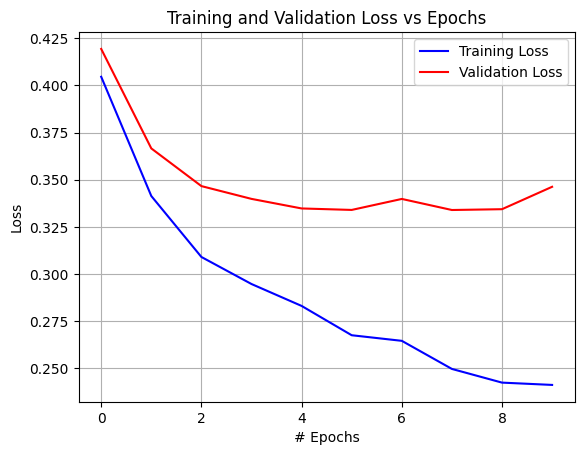

Test Cost: 0.37184542911674484 	 Test Accuracy: 0.975


In [ ]:
# Run test set on best model
def main():
  # Load the Fashion MNIST dataset
  with wandb.init() as run:
    (x, y), (x_test, y_test) = fashion_mnist.load_data()
    nn = NeuralNetwork(x, y, x_test, y_test)
    nn.preprocess()
    nn.split_data()
    nn.print_data_details()
    _, _, y_test = nn.one_hot_encod()

    # Best hyperparameters after tuning with wandb
    epochs = 10
    num_hidden_layers = 3
    num_neurons = 128
    learning_rate = 1e-3
    act_fn = 'relu'
    optimizer = 'adam'
    batch_size = 128
    weight_init = 'xavier'
    l2_reg = 0.0005
    parameters = nn.train_model(epochs, num_hidden_layers, num_neurons,
                                learning_rate, act_fn, weight_init,
                                optimizer, batch_size, l2_reg)
    y_hat, _, _ = nn.test_model(parameters, num_hidden_layers, num_neurons, act_fn, l2_reg)
    # create confusion matrix in wandb  #https://wandb.ai/wandb/plots/reports/Confusion-Matrix-Usage-and-Examples--VmlldzozMDg1NTM
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    ground_truth_class_ids = y_test.T.argmax(axis=1)
    top_pred_ids = y_hat.T.argmax(axis=1)
    wandb.log({"confusion_matrix" : wandb.plot.confusion_matrix(
                preds = top_pred_ids, y_true = ground_truth_class_ids,
                class_names= classes )})
wandb.agent(sweep_id, function = main, count = 1)   # calls main function for count number of times
wandb.finish()